This notebook will be used for the following analysis:

> Importing articles from Guardian API

> Using spacy for entity recognition, specifically Locations and Organizations mentioned

> Clustering visualisation and topic modelling using word vectors and t-SNE to identify similar articles
>> (Nearest neighbors to generate a list?)


> Create a knowledge graph using the entity recognition, and visualising using igraph

In [25]:
import pandas as pd
from pandas import json_normalize
import en_core_web_sm
from sklearn.manifold import TSNE
import pyLDAvis
import requests
import os
import networkx as nx
import ipywidgets as widgets
%matplotlib inline

# Retrieve environment variables (for API keys, etc.)
from dotenv import load_dotenv
#%dotenv # automatically detects the location of the .env file
load_dotenv()

%load_ext autoreload
%autoreload 2
%aimport article_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
API_KEY = os.environ["GUARDIAN_API"]

#### 1. Generate our article dataset via the Guardian's API - [Get yours here](https://open-platform.theguardian.com/access/) 

In [7]:
def search_guardian_articles(api_key, search_term='', page=1, page_size=100, format_='json'):
    '''Retrieves meta data of articles matching the search term'''
    search_term = search_term.replace(' ', '%20')
    
    # Now, we'll make the request
    url = 'https://content.guardianapis.com/search'
    params = {'api-key':API_KEY,
             'format':'json',
              'page':page,
              'page-size':page_size,
             'q':search_term}
    response = requests.get(url, params=params)
    return response.json()

In [10]:
def guardian_articles_dataframe(api_key, search_term='', number_of_records=100):
    '''Returns a dataframe with article information from the Guardian API
    
    var:
        search_term: Query string passed to the Guardian API to search the server database
        
        api_key: key required to access the Guardian API. Available for free from Guardian Developer website
        
        number_of_records: Indicates the  number of records to return in the dataframe'''
    # Instantiate the pandas dataframe
    df = pd.DataFrame()
    
    # Iterate through a series of API calls to retrieve the records, and append to dataframe
    for i in range(1,int(number_of_records / 200 + 1)):
        try:
            data = json_normalize(search_guardian_articles(api_key=API_KEY, search_term=search_term, page_size=200, page=i)['response']['results'])
            df = df.append(data)
        except:
            break
    
    # Reset index and return the dataframe
    df = df.reset_index(drop=True)
    return df[:number_of_records]

In [44]:
# Search the Guardian API with a term to get our dataset
term = input('Search the Guardian API')

df = guardian_articles_dataframe(api_key=API_KEY, search_term=term, number_of_records=1000)
df.head()

Search the Guardian APIhousing


,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,isHosted,pillarId,pillarName
0,politics/2020/jun/25/the-three-housing-controv...,article,politics,Politics,2020-06-25T15:08:45Z,The three housing controversies Robert Jenrick...,https://www.theguardian.com/politics/2020/jun/...,https://content.guardianapis.com/politics/2020...,False,pillar/news,News
1,world/2020/jul/03/covid-19-exposes-stark-gener...,article,world,World news,2020-07-03T08:52:40Z,Covid-19 exposes stark generational housing di...,https://www.theguardian.com/world/2020/jul/03/...,https://content.guardianapis.com/world/2020/ju...,False,pillar/news,News
2,society/2020/jun/21/hunger-violence-cramped-ho...,article,society,Society,2020-06-21T06:17:08Z,"Hunger, violence, cramped housing: lockdown li...",https://www.theguardian.com/society/2020/jun/2...,https://content.guardianapis.com/society/2020/...,False,pillar/news,News
3,world/2020/apr/28/tuesday-briefing-virus-puts-...,article,world,World news,2020-04-28T05:32:46Z,Tuesday briefing: Virus puts brake on housing ...,https://www.theguardian.com/world/2020/apr/28/...,https://content.guardianapis.com/world/2020/ap...,False,pillar/news,News
4,business/2020/may/13/uk-property-market-could-...,article,business,Business,2020-05-13T16:12:12Z,"UK property market could fall 13%, housing exp...",https://www.theguardian.com/business/2020/may/...,https://content.guardianapis.com/business/2020...,False,pillar/news,News


In [45]:
#sections_to_keep = ['Science','Society','Politics','Money','News','Culture','Environment','Business','Media','Art and design',
#                   'UK news','Technology','Cities','Education','Global development','Law','Housing Network','Community']
#df = df[df.sectionName.isin(sections_to_keep)].reset_index(drop=True)

In [47]:
from article_analysis.data import TextProcessing

# Process the text of the article titles in preparation for topic modelling. The custom function in the code will remove stop words,
# lemmatize (stem) the words, remove digits, and other steps - depending on options selected.
processed_article_title = [ TextProcessing.preprocess_text(x, detect_language=False, lemmatize=False,no_digits=True) for x in df.webTitle ]

# Add this list as a column in the dataframe
df['processed_article_title'] = processed_article_title

In [48]:
from article_analysis.models import TopicModeller

tm = TopicModeller(df)

tm.generate_word_vector_plot(column='webTitle')

In [51]:
tm.topic_count = 3
tm.generate_lda_visualisation(df.processed_article_title)

In [52]:
entity_types = ['ORG','PERSON','FAC','GPE','LOC','EVENT','WORK_OF_ART']
title_entities = [ TextProcessing.list_of_entities(x, entity_type=entity_types) for x in df.webTitle ]

In [53]:
df['entities_mentioned'] = [ title_entities[x][0] for x in range(len(title_entities)) ]
df['entities_labels'] = [ title_entities[x][1] for x in range(len(title_entities)) ]

In [54]:
df.head()

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,isHosted,pillarId,pillarName,processed_article_title,entities_mentioned,entities_labels
0,politics/2020/jun/25/the-three-housing-controv...,article,politics,Politics,2020-06-25T15:08:45Z,The three housing controversies Robert Jenrick...,https://www.theguardian.com/politics/2020/jun/...,https://content.guardianapis.com/politics/2020...,False,pillar/news,News,three housing controversies robert jenrick facing,[Robert Jenrick],[PERSON]
1,world/2020/jul/03/covid-19-exposes-stark-gener...,article,world,World news,2020-07-03T08:52:40Z,Covid-19 exposes stark generational housing di...,https://www.theguardian.com/world/2020/jul/03/...,https://content.guardianapis.com/world/2020/ju...,False,pillar/news,News,covid exposes stark generational housing divid...,[Covid-19 exposes stark generational housing d...,"[ORG, GPE]"
2,society/2020/jun/21/hunger-violence-cramped-ho...,article,society,Society,2020-06-21T06:17:08Z,"Hunger, violence, cramped housing: lockdown li...",https://www.theguardian.com/society/2020/jun/2...,https://content.guardianapis.com/society/2020/...,False,pillar/news,News,hunger violence cramped housing lockdown life ...,[],[]
3,world/2020/apr/28/tuesday-briefing-virus-puts-...,article,world,World news,2020-04-28T05:32:46Z,Tuesday briefing: Virus puts brake on housing ...,https://www.theguardian.com/world/2020/apr/28/...,https://content.guardianapis.com/world/2020/ap...,False,pillar/news,News,tuesday briefing virus puts brake housing market,[Virus],[ORG]
4,business/2020/may/13/uk-property-market-could-...,article,business,Business,2020-05-13T16:12:12Z,"UK property market could fall 13%, housing exp...",https://www.theguardian.com/business/2020/may/...,https://content.guardianapis.com/business/2020...,False,pillar/news,News,uk property market could fall housing experts ...,[UK],[GPE]


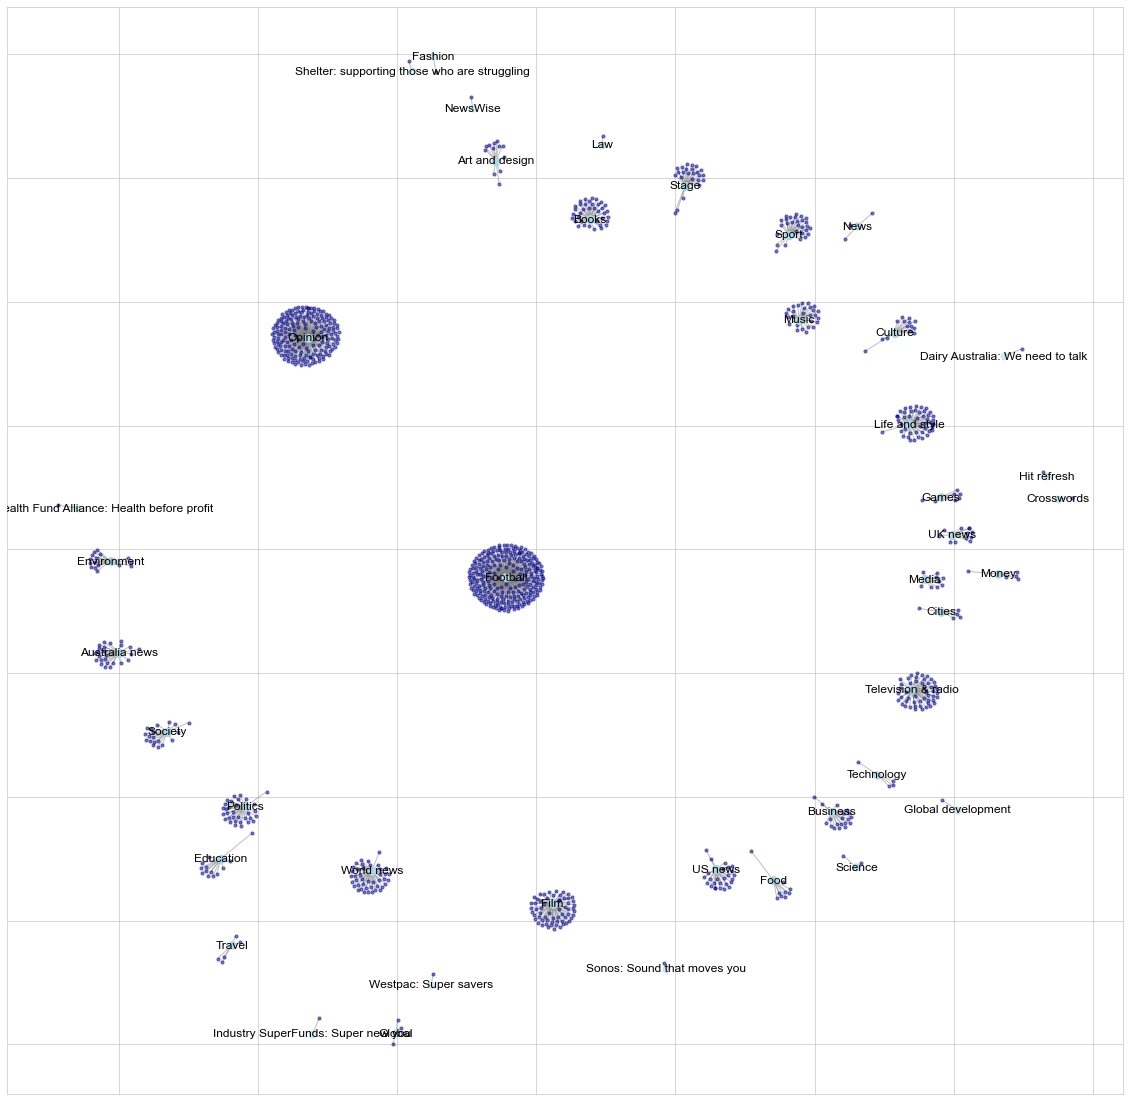

In [121]:
from networkx import Graph
import matplotlib.pyplot as plt

df = df.head(1000)

titles = [x for x in df.webTitle ]
sections = [x for x in df.sectionName ]
nodes = titles + sections
nodes = list(set(nodes))
edges = list(zip(titles, sections))

plt.figure(figsize=(20,20))
g = Graph()


g.add_nodes_from(titles, label='article')
g.add_nodes_from(sections, label='section')
g.add_edges_from(edges)

labels = {}
for node in g.nodes():
    if node in sections:
        labels[node] = node

#nx.draw(g, node_size=50)
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g,pos=pos,
                       nodelist=titles,
                       node_color='darkblue',
                       node_size=10,
                       alpha=0.5)

nx.draw_networkx_nodes(g,pos=pos,
                       nodelist=sections,
                       node_color='lightblue',
                       node_size=50,
                       alpha=0.5)

nx.draw_networkx_labels(g, pos=pos,
                        labels=labels)

nx.draw_networkx_edges(g,pos=pos,
                       edgelist=edges,
                       width=1,alpha=0.5,edge_color='grey')


plt.show()